<a href="https://colab.research.google.com/github/PolMix/nems_ai/blob/main/Classic%20ML/cross_validation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Lib import

In [ ]:
import pandas as pd
import numpy as np
import scipy.stats as sps
import seaborn as sns

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import axes3d
from matplotlib import cm

# Удобства
from tqdm import tqdm

import warnings
warnings.filterwarnings('ignore')

In [ ]:
# Модели
from sklearn.multioutput import MultiOutputRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.base import clone

from xgboost import XGBRegressor

# Метрики качества
from time import time

from sklearn.metrics import r2_score, mean_squared_error

# Обработка датасета, кроссвалидация
from sklearn.model_selection import train_test_split, KFold, cross_validate

# Нормировка датасета
from sklearn.preprocessing import RobustScaler, StandardScaler

# Скачивание данных и скриптов

Загружаем датасет с GitHub:

In [ ]:
import zipfile
import os

!wget --no-check-certificate \
    "https://github.com/PolMix/nems_ai/archive/refs/heads/main.zip" \
    -O "/tmp/data.zip"


zip_ref = zipfile.ZipFile('/tmp/data.zip', 'r') #Opens the zip file in read mode
zip_ref.extractall('/tmp') #Extracts the files into the /tmp folder
zip_ref.close()

--2023-06-11 05:30:49--  https://github.com/PolMix/nems_ai/archive/refs/heads/main.zip
Resolving github.com (github.com)... 192.30.255.112
Connecting to github.com (github.com)|192.30.255.112|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://codeload.github.com/PolMix/nems_ai/zip/refs/heads/main [following]
--2023-06-11 05:30:49--  https://codeload.github.com/PolMix/nems_ai/zip/refs/heads/main
Resolving codeload.github.com (codeload.github.com)... 192.30.255.121
Connecting to codeload.github.com (codeload.github.com)|192.30.255.121|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: unspecified [application/zip]
Saving to: ‘/tmp/data.zip’

/tmp/data.zip           [      <=>           ]  15.86M  6.63MB/s    in 2.4s    

2023-06-11 05:30:52 (6.63 MB/s) - ‘/tmp/data.zip’ saved [16626164]



In [ ]:
%cd '/tmp/nems_ai-main/Data Processed'
filename = 'Dataset_Processed.csv'
df = pd.read_csv(filename)
df = df.sample(frac=1).reset_index(drop=True)
df = df.drop(columns='Unnamed: 0')
df.head()

/tmp/nems_ai-main/Data Processed


,Beam length (um),Beam width (nm),Thickness_1 (nm),Thickness_2 (nm),Temperature (K),Distance (nm),Gate voltage (V),Pretension (Pa),M1 Eigenfrequency (Hz),M1 Quality factor,...,M3 Eigenfrequency (Hz),M3 Quality factor,M3 Effective mass (kg),M3 Noise (kg^2/s^3),M3 TED (W),M4 Eigenfrequency (Hz),M4 Quality factor,M4 Effective mass (kg),M4 Noise (kg^2/s^3),M4 TED (W)
0,313.402811,803.644865,177.999886,40.608258,1.913197,492.811004,0.000000,6.434784e+08,8.806354e+05,1.716778e+06,...,2.655894e+06,1.671593e+06,8.102159e-14,1.384771e-28,1.861428e-11,3.557429e+06,1.621500e+06,8.107292e-14,1.913341e-28,2.456350e-11
1,98.763536,169.330129,182.221371,36.062926,0.020359,268.781702,8.850473,0.000000e+00,1.427304e+06,3.156215e+07,...,4.322429e+06,3.156467e+07,5.348770e-15,8.443005e-32,4.992173e-13,5.810084e+06,2.476164e+07,5.354168e-15,1.448143e-31,1.113676e-12
2,57.831630,165.790252,144.194738,34.449627,88.611243,542.888653,0.000000,9.879121e+08,5.458910e+06,6.487605e+04,...,1.645848e+07,6.158467e+04,2.522314e-15,9.863192e-25,3.386345e-12,2.203956e+07,5.899697e+04,2.523547e-15,1.379386e-24,4.159988e-12
3,109.175852,645.739487,109.837553,22.613391,0.127629,245.259397,0.000000,7.254112e+08,2.720271e+06,7.426590e+07,...,8.370134e+06,1.758784e+07,1.347156e-14,3.791202e-30,1.249383e-11,1.139719e+07,9.443948e+05,1.351512e-14,9.645020e-29,1.501472e-11
4,50.989778,399.795578,103.777768,36.350101,1.464425,419.411889,37.177933,7.202576e+08,6.023740e+06,8.326876e+06,...,1.879593e+07,7.091089e+06,4.033627e-15,3.325758e-28,7.201388e-12,2.586718e+07,6.368951e+06,4.048139e-15,5.114233e-28,8.529655e-12


# Подготовка данных

Делаем несколько действий:
- разбиваем датасет на тренировочную + валидационную часть и тестовую часть
- разбиваем трен-вал датасет на X и Y данные
- разбиваем тест датасет на X и Y данные

In [ ]:
len_test = 0.2 # доля объектов на тренировку и валидацию из изначального датасета
len_val = 0.2 # доля объектов на валидацию из трен-вал датасета

mode_number = 4

df_trainval, df_test = train_test_split(df, test_size=len_test, random_state=42, shuffle=True)
df_train, df_val = train_test_split(df_trainval, test_size=len_val, random_state=42, shuffle=True)

Разделение данных на тренировочную, валидационную и тестовую части:

Разбиение подвыборок на X и Y данные:

In [ ]:
%cd '/tmp/nems_ai-main/Scripts'
from dataset_preprocessing_pandas import split_df

x_train, y_train = split_df(df_train, num_common=8)
x_val, y_val = split_df(df_val, num_common=8)
x_test, y_test = split_df(df_test, num_common=8)

print('Dataset has been split into parts with the following shapes:')
print(f'x_train: {x_train.shape}')
print(f'y_train: {y_train.shape}')
print(f'x_val: {x_val.shape}')
print(f'y_val: {y_val.shape}')
print(f'x_test: {x_test.shape}')
print(f'y_test: {y_test.shape}')

/tmp/nems_ai-main/Scripts
Dataset has been split into parts with the following shapes:
x_train: (3141, 8)
y_train: (3141, 20)
x_val: (786, 8)
y_val: (786, 20)
x_test: (982, 8)
y_test: (982, 20)


In [ ]:
x_test.head()

,Beam length (um),Beam width (nm),Thickness_1 (nm),Thickness_2 (nm),Temperature (K),Distance (nm),Gate voltage (V),Pretension (Pa)
4153,462.390468,502.394179,118.455814,46.358215,0.816851,462.012908,16.956125,0.000000e+00
3543,21.872165,87.510398,149.089563,42.535166,0.397188,477.538421,10.121410,7.193928e+08
907,312.983522,903.062868,193.682337,47.662807,23.726920,116.571088,20.441359,5.043367e+08
2522,41.128594,850.435614,199.002962,23.876786,35.159319,373.667227,15.744060,5.183000e+08
3107,315.698458,474.013577,188.469196,43.350160,46.217139,516.295997,8.007017,5.316246e+08


In [ ]:
y_train.head()

,M1 Eigenfrequency (Hz),M1 Quality factor,M1 Effective mass (kg),M1 Noise (kg^2/s^3),M1 TED (W),M2 Eigenfrequency (Hz),M2 Quality factor,M2 Effective mass (kg),M2 Noise (kg^2/s^3),M2 TED (W),M3 Eigenfrequency (Hz),M3 Quality factor,M3 Effective mass (kg),M3 Noise (kg^2/s^3),M3 TED (W),M4 Eigenfrequency (Hz),M4 Quality factor,M4 Effective mass (kg),M4 Noise (kg^2/s^3),M4 TED (W)
3781,2.144831e+06,2.025362e+07,1.599432e-14,1.703130e-30,3.185451e-12,4.323336e+06,1.976741e+07,1.602537e-14,3.524269e-30,8.361233e-12,6.568117e+06,6.562217e+06,1.607055e-14,1.617383e-29,1.156710e-11,8.909765e+06,3.409115e+05,1.611478e-14,4.234877e-28,1.398644e-11
2200,2.920596e+06,1.081055e+06,1.076484e-14,2.629355e-27,3.779160e-12,5.940861e+06,1.033748e+06,1.083219e-14,5.628192e-27,5.314036e-12,9.153322e+06,9.688909e+05,1.090620e-14,9.315259e-27,6.704370e-12,1.263836e+07,8.990692e+05,1.094899e-14,1.391520e-26,7.910170e-12
4798,6.557688e+06,1.092011e+07,6.006809e-15,2.150824e-28,6.343519e-12,1.369608e+07,9.585506e+06,6.138309e-15,5.229585e-28,8.499927e-12,2.188434e+07,8.218180e+06,6.207706e-15,9.856580e-28,1.019685e-11,3.144320e+07,7.096995e+06,6.214150e-15,1.641614e-27,1.146335e-11
963,7.103857e+06,2.335265e+07,7.284582e-15,2.389705e-29,4.634836e-12,1.555743e+07,2.030254e+07,7.626285e-15,6.302051e-29,5.807200e-12,2.621611e+07,1.771934e+07,7.697836e-15,1.228206e-28,6.586126e-12,3.947628e+07,1.581518e+07,7.676323e-15,2.066316e-28,7.114950e-12
3965,5.585116e+07,2.883601e+04,1.413145e-15,1.980694e-23,4.728518e-12,1.402660e+08,2.659885e+04,1.553153e-15,5.927034e-23,5.082129e-12,2.559515e+08,2.545647e+04,1.538462e-15,1.119386e-22,5.365175e-12,3.573118e+08,2.331254e+04,5.523106e-16,6.125969e-23,1.062590e-11


Выполняем логарифмирование и скейлинг:

In [ ]:
from dataset_preprocessing_pandas import Scaler as Scaler

scaler_x = StandardScaler()
scaler_y = StandardScaler()

mode_number = 4
s = Scaler(scaler_x, scaler_y, mode_number)
s.fit(x_train=x_train, y_train=y_train)

x_train, y_train = s.transform(x_train, y_train)
x_val, y_val = s.transform(x_val, y_val)
x_test, y_test = s.transform(x_test, y_test)

In [ ]:
y_test.describe()

,M1 Eigenfrequency (Hz),M1 Quality factor,M1 Effective mass (kg),M1 Noise (kg^2/s^3),M1 TED (W),M2 Eigenfrequency (Hz),M2 Quality factor,M2 Effective mass (kg),M2 Noise (kg^2/s^3),M2 TED (W),M3 Eigenfrequency (Hz),M3 Quality factor,M3 Effective mass (kg),M3 Noise (kg^2/s^3),M3 TED (W),M4 Eigenfrequency (Hz),M4 Quality factor,M4 Effective mass (kg),M4 Noise (kg^2/s^3),M4 TED (W)
count,982.000000,982.000000,982.000000,982.000000,982.000000,982.000000,982.000000,982.000000,982.000000,982.000000,982.000000,982.000000,982.000000,982.000000,982.000000,982.000000,982.000000,982.000000,982.000000,982.000000
mean,-0.063954,-0.034238,0.049786,-0.002725,-0.061011,-0.063804,-0.032596,0.049368,-0.004292,-0.059138,-0.063703,-0.031304,0.049229,-0.005506,-0.045916,-0.063258,-0.018071,0.053404,-0.010713,-0.037032
std,1.010326,0.981016,1.023992,0.990604,0.994228,1.009671,0.980894,1.024020,0.990626,0.996932,1.009328,0.978886,1.023904,0.989959,1.006030,1.010788,0.986839,1.016894,0.998207,1.015999
min,-2.239297,-2.608104,-2.656522,-2.329499,-3.531155,-2.154430,-2.584027,-2.651755,-2.310874,-3.703171,-2.075202,-2.560274,-2.651899,-2.327751,-3.890293,-2.047715,-2.648188,-2.588268,-2.251352,-4.038129
25%,-0.895522,-0.743232,-0.736444,-0.758279,-0.710173,-0.894080,-0.729251,-0.749351,-0.750412,-0.553811,-0.892555,-0.746619,-0.747098,-0.752424,-0.548317,-0.893701,-0.729049,-0.715852,-0.751355,-0.589355
50%,-0.120603,-0.022496,0.036011,0.026551,0.202181,-0.141714,-0.018176,0.041121,0.018879,0.091533,-0.157080,-0.036484,0.045305,0.011569,0.003298,-0.168107,-0.043277,0.057888,0.005989,-0.002877
75%,0.677534,0.669846,0.844024,0.753041,0.653638,0.685971,0.688421,0.840015,0.753056,0.640941,0.682280,0.696864,0.841339,0.748406,0.650234,0.680990,0.698789,0.841358,0.741322,0.676449
max,2.309647,2.597671,2.200567,2.864526,2.047347,2.359660,2.590473,2.208131,2.859803,2.205864,2.364087,2.583234,2.206839,2.832947,2.297970,2.187013,2.678875,2.177825,2.769916,2.317183


# Визуализация распределения нормированных параметров

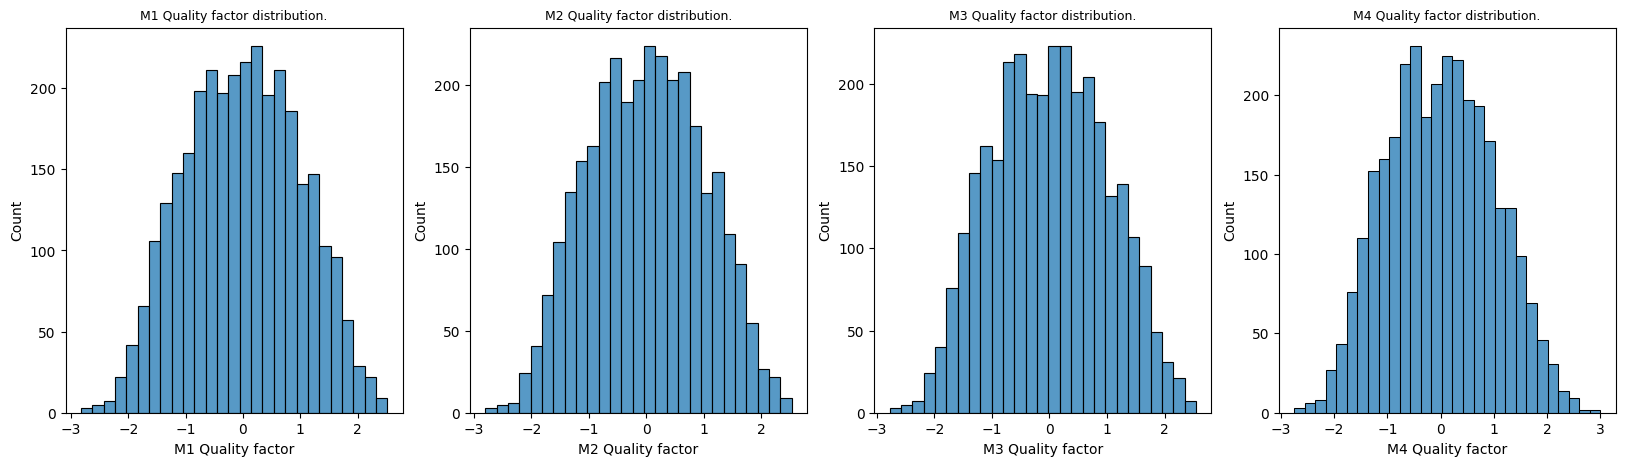

In [ ]:
from classic_ml import plot_distribution

plot_distribution(df=y_train, param_name='Quality factor',
                  log_scale=False, font_size=0.25)

# Кросс-валидация

### Импорт необходимых скриптов

In [ ]:
%cd '/tmp/nems_ai-main/Scripts'
from classic_ml import get_elapsed_time, calculate_metrics
from classic_ml import plot_metrics, plot_metrics_dense, compare_models
from classic_ml import CustomCV

/tmp/nems_ai-main/Scripts


### XGBRegressor + Custom Cross-validation

#### Выполнение кастомной кросс-валидации:

In [ ]:
# Параметры для обучения XGBRegressor
params = {'max_depth': 4, 'learning_rate': 0.058736919301307394, 'n_estimators': 584, 'min_child_weight': 8, 'gamma': 0.014285497344490779, 'subsample': 0.7531664932484148, 'reg_alpha': 0.03207830795055566, 'reg_lambda': 3.7172242115107922e-06, 'n_jobs': -1}

# Создание модели XGBRegressor
model_xgb_CV = XGBRegressor(**params)

# Данные для кроссвалидации
x_trainval = pd.concat([x_train, x_val], axis=0)
y_trainval = pd.concat([y_train, y_val], axis=0)

kf = CustomCV(model=model_xgb_CV, n_splits=10, shuffle=True, random_state=32)
metrics_log, train_indices_log, val_indices_log = kf.cross_validate(x_trainval=x_trainval, y_trainval=y_trainval, return_indices=True)

1it [00:50, 50.81s/it]

 Fold N1 is processed!


2it [01:40, 50.41s/it]

 Fold N2 is processed!


3it [02:30, 49.87s/it]

 Fold N3 is processed!


4it [03:21, 50.28s/it]

 Fold N4 is processed!


5it [04:10, 49.99s/it]

 Fold N5 is processed!


6it [05:00, 49.87s/it]

 Fold N6 is processed!


7it [05:50, 49.87s/it]

 Fold N7 is processed!


8it [06:41, 50.43s/it]

 Fold N8 is processed!


9it [07:30, 49.97s/it]

 Fold N9 is processed!


10it [08:19, 49.95s/it]

 Fold N10 is processed!


In [ ]:
print(metrics_log)

[{'M1 Eigenfrequency (Hz)': [0.0008575773241625957, 0.9991328448213745], 'M1 Quality factor': [0.026019993147784557, 0.9744854386085783], 'M1 Effective mass (kg)': [0.0016542452500559926, 0.9982343427946736], 'M1 Noise (kg^2/s^3)': [0.00574051457605174, 0.9945497713270169], 'M1 TED (W)': [0.01991899871016335, 0.9811734464114819], 'M2 Eigenfrequency (Hz)': [0.0008583864572095344, 0.9991354469726003], 'M2 Quality factor': [0.020928919838628317, 0.9794639948077697], 'M2 Effective mass (kg)': [0.0016614169756650967, 0.9982245811542562], 'M2 Noise (kg^2/s^3)': [0.005750725742776625, 0.9945368216962854], 'M2 TED (W)': [0.024111733274556714, 0.9768751542760659], 'M3 Eigenfrequency (Hz)': [0.0008847682618565711, 0.9991110228978561], 'M3 Quality factor': [0.026899405976229574, 0.9737538330286715], 'M3 Effective mass (kg)': [0.0016974446553907408, 0.9981871133247747], 'M3 Noise (kg^2/s^3)': [0.006743970003858813, 0.9935986205567542], 'M3 TED (W)': [0.026175412767242952, 0.9742446654152456], 'M4 

Started plotting metrics.
Metrics have been successfully plotted!
Started plotting X-data distribution.


100%|██████████| 8/8 [00:00<00:00,  9.83it/s]


X-data distribution has been successfully plotted!
Started plotting Y-data distribution.


100%|██████████| 20/20 [00:01<00:00, 10.02it/s]


Y-data disribution has been successfully plotted!


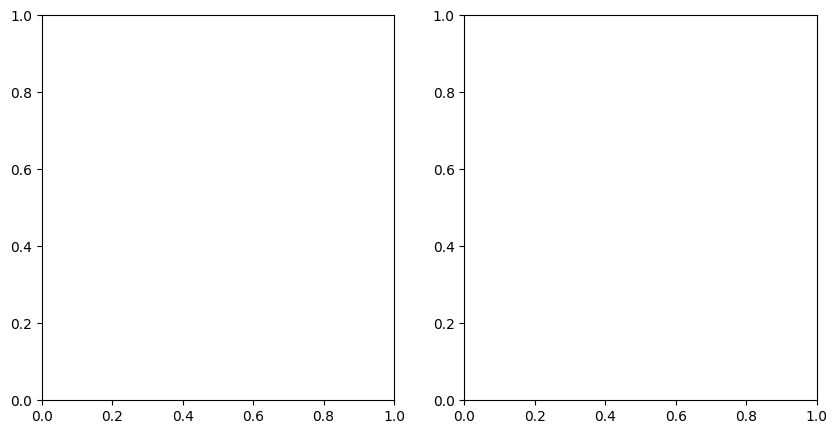

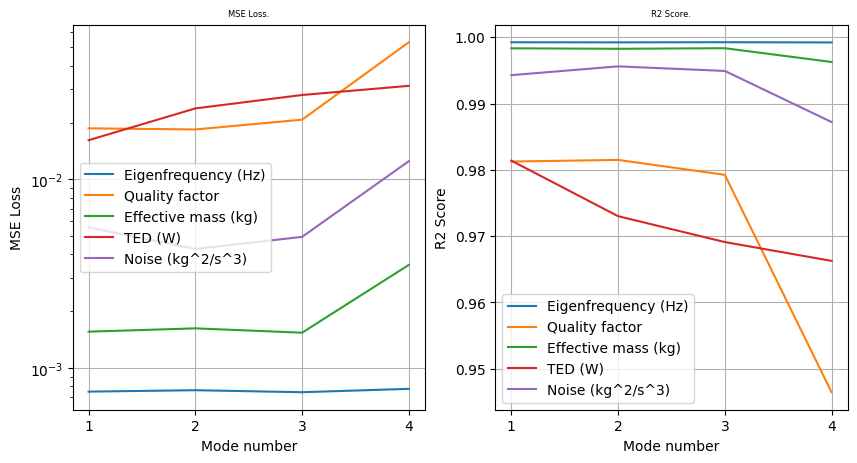

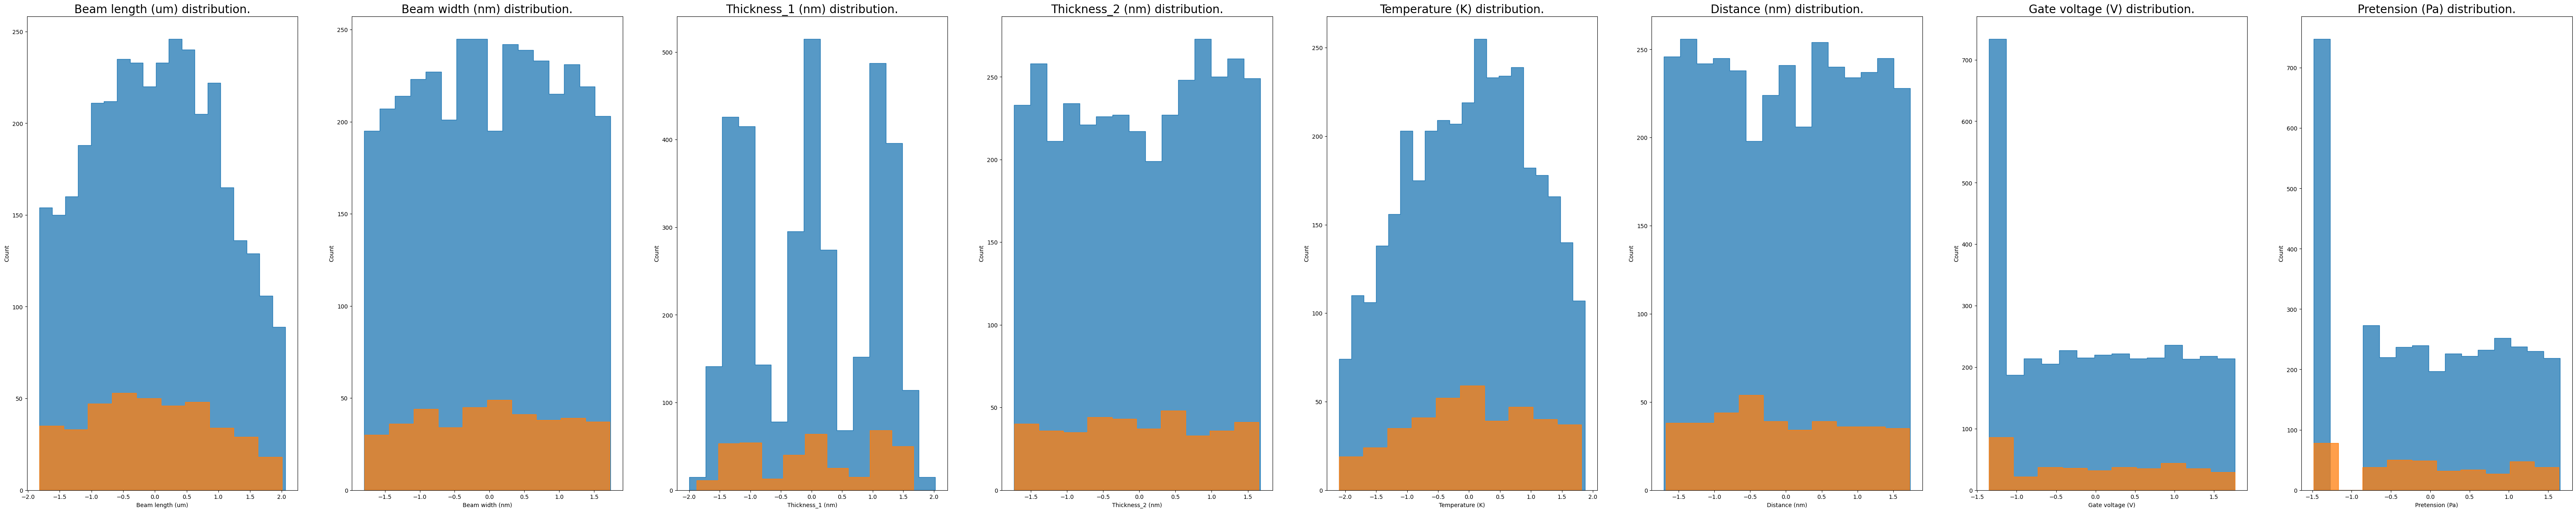

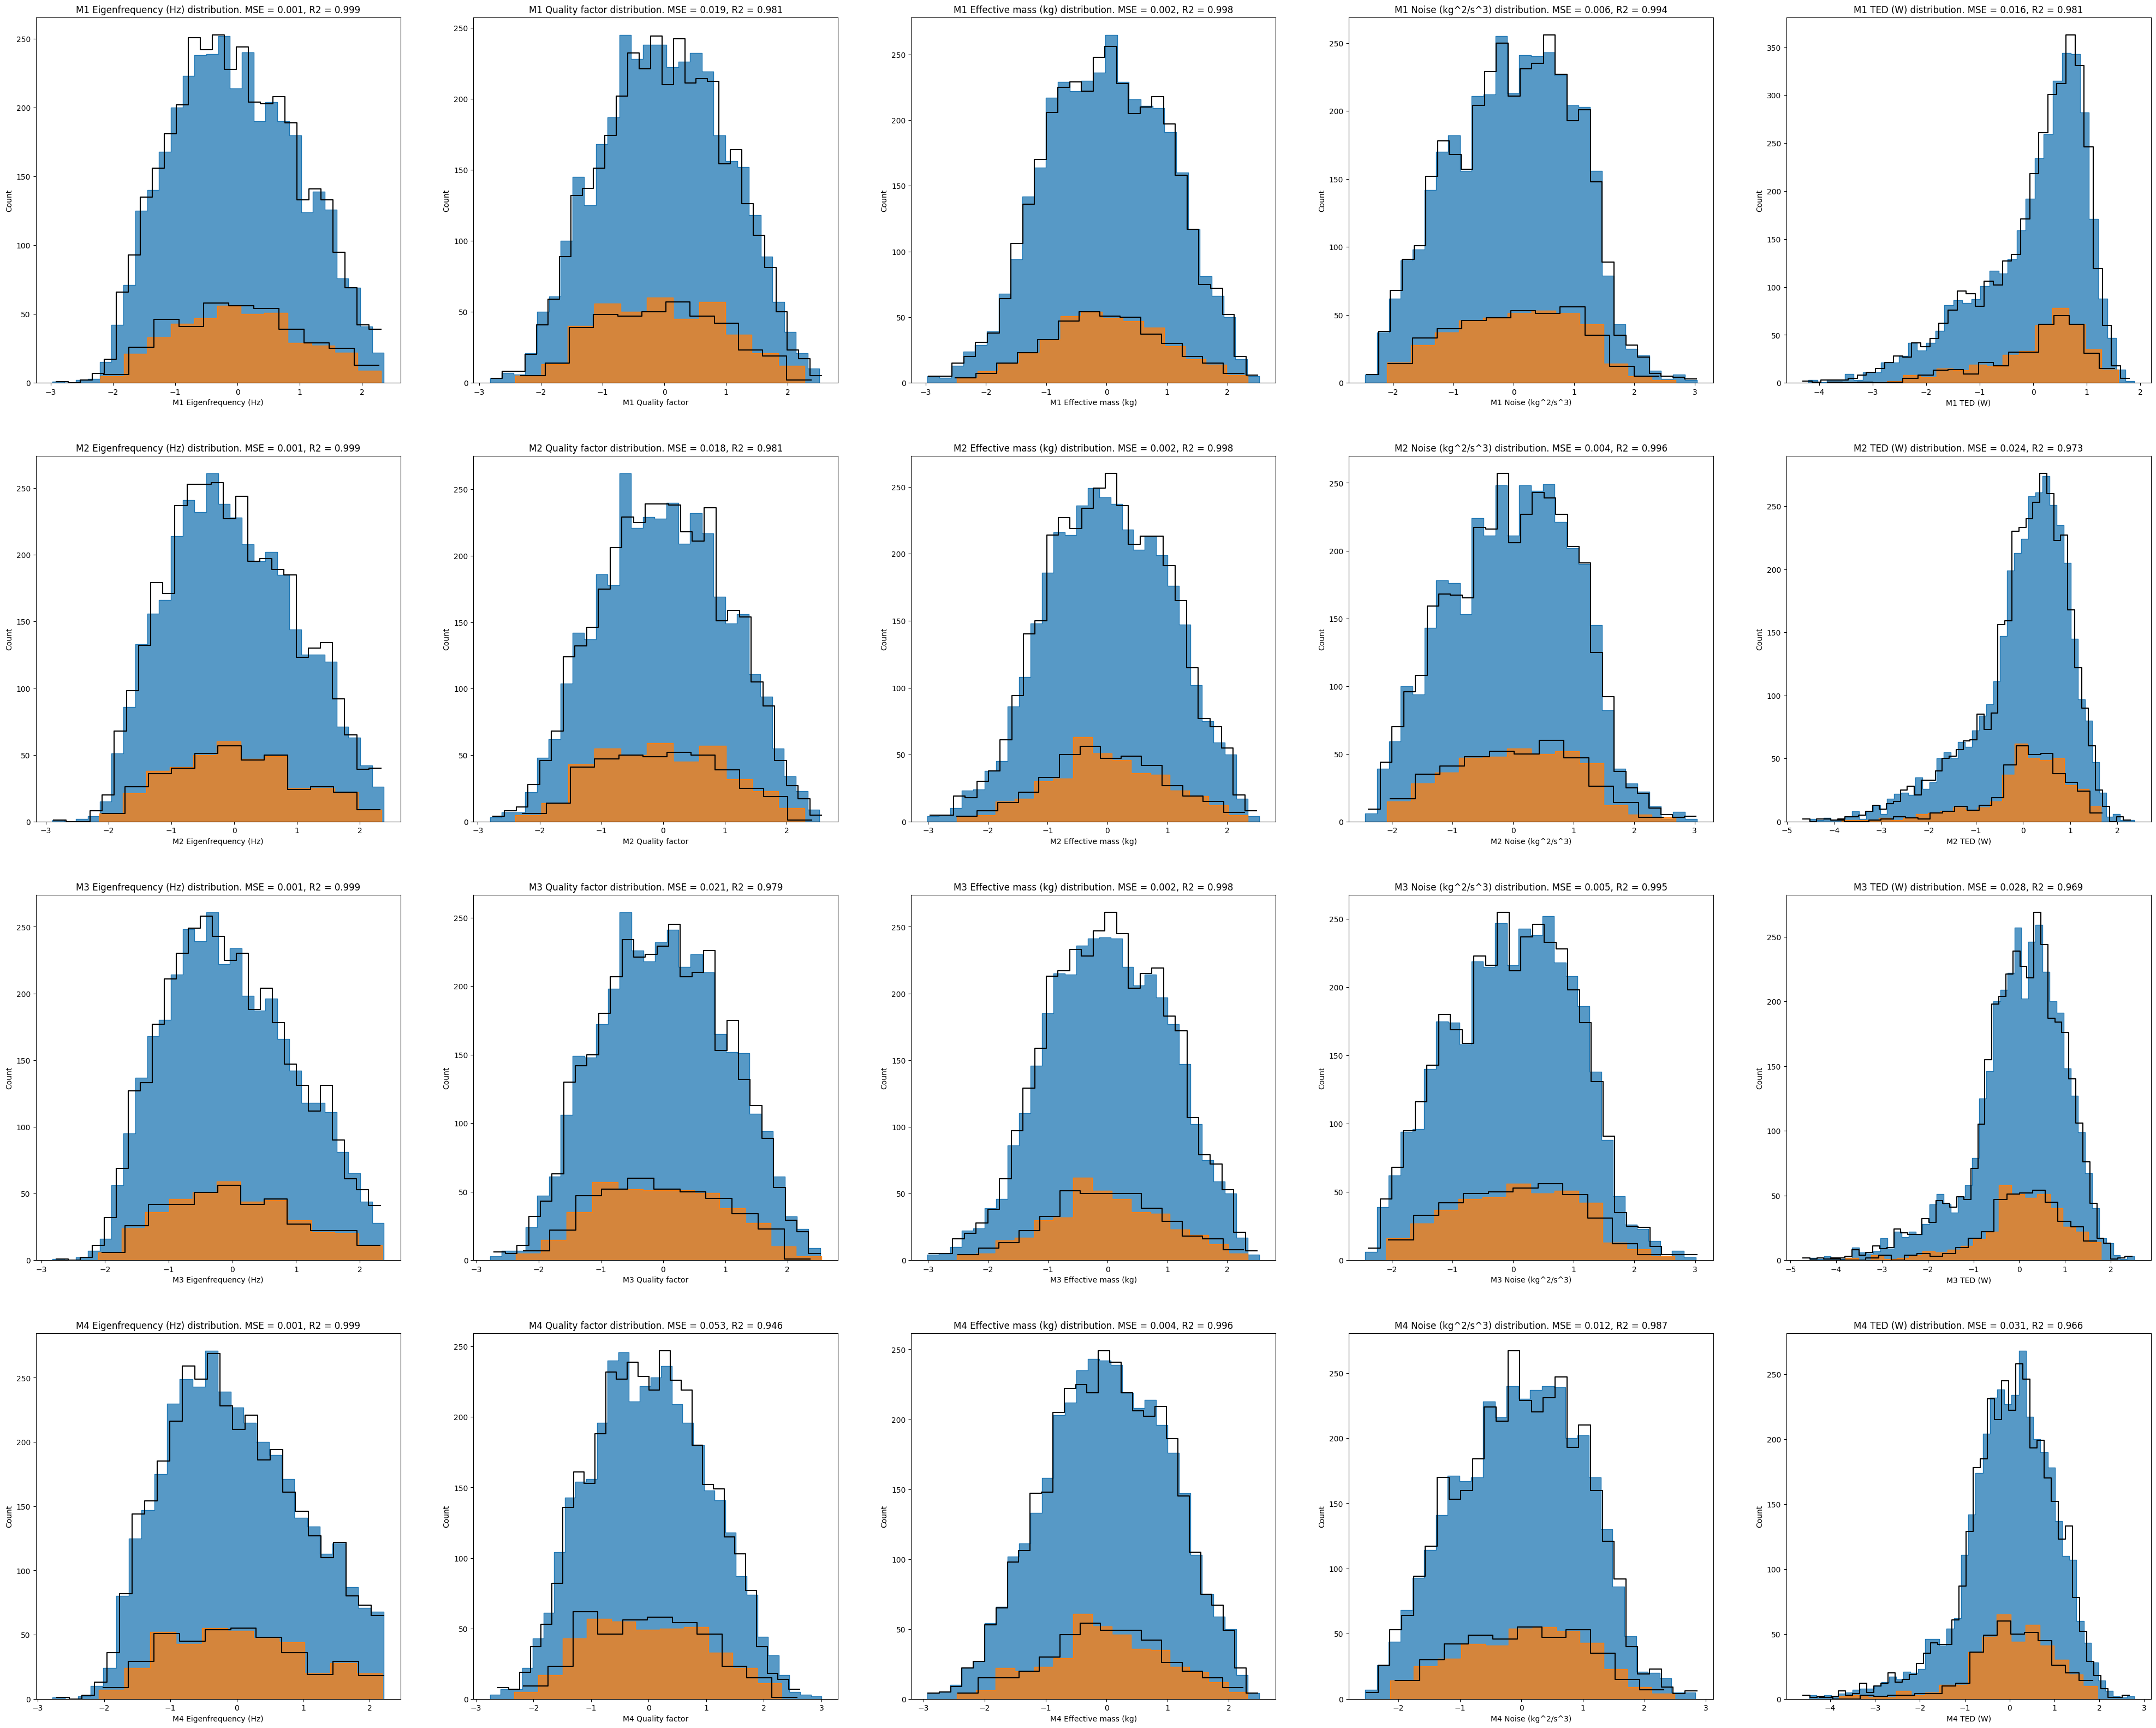

In [ ]:
kf.plot_distribution_trainval(fold_index=4, log_scale=False)

Что изображено на этих графиках:

**Ряд 1**: два пустых графика (это недоработка в методах класса)

**Ряд 2**: графики MSE и R2 метрик на выбранном фолде

**Ряд 3**: распределение X-данных на выбранном фолде (синий цвет - тренировочная часть фолда, коричневый - валидационная)

**Ряд 4, 5, 6, 7**: распределение истинных и предсказанных значений (истинные значения обозначены цветом - синим и коричневым, а предсказанные - двумя черными полосками) на выбранном фолде. Порядковый номер ряда соответствует номеру моды колебаний.

На графике ниже вы можете наблюдать кривые метрик MSE и R2 в зависимости от номера фолда (откладывается по оси `x`). В верхней строке - MSE ошибка, в нижней - коэффициент R2. По столбцам отложены пять параметров, номера мод указываются цветом.

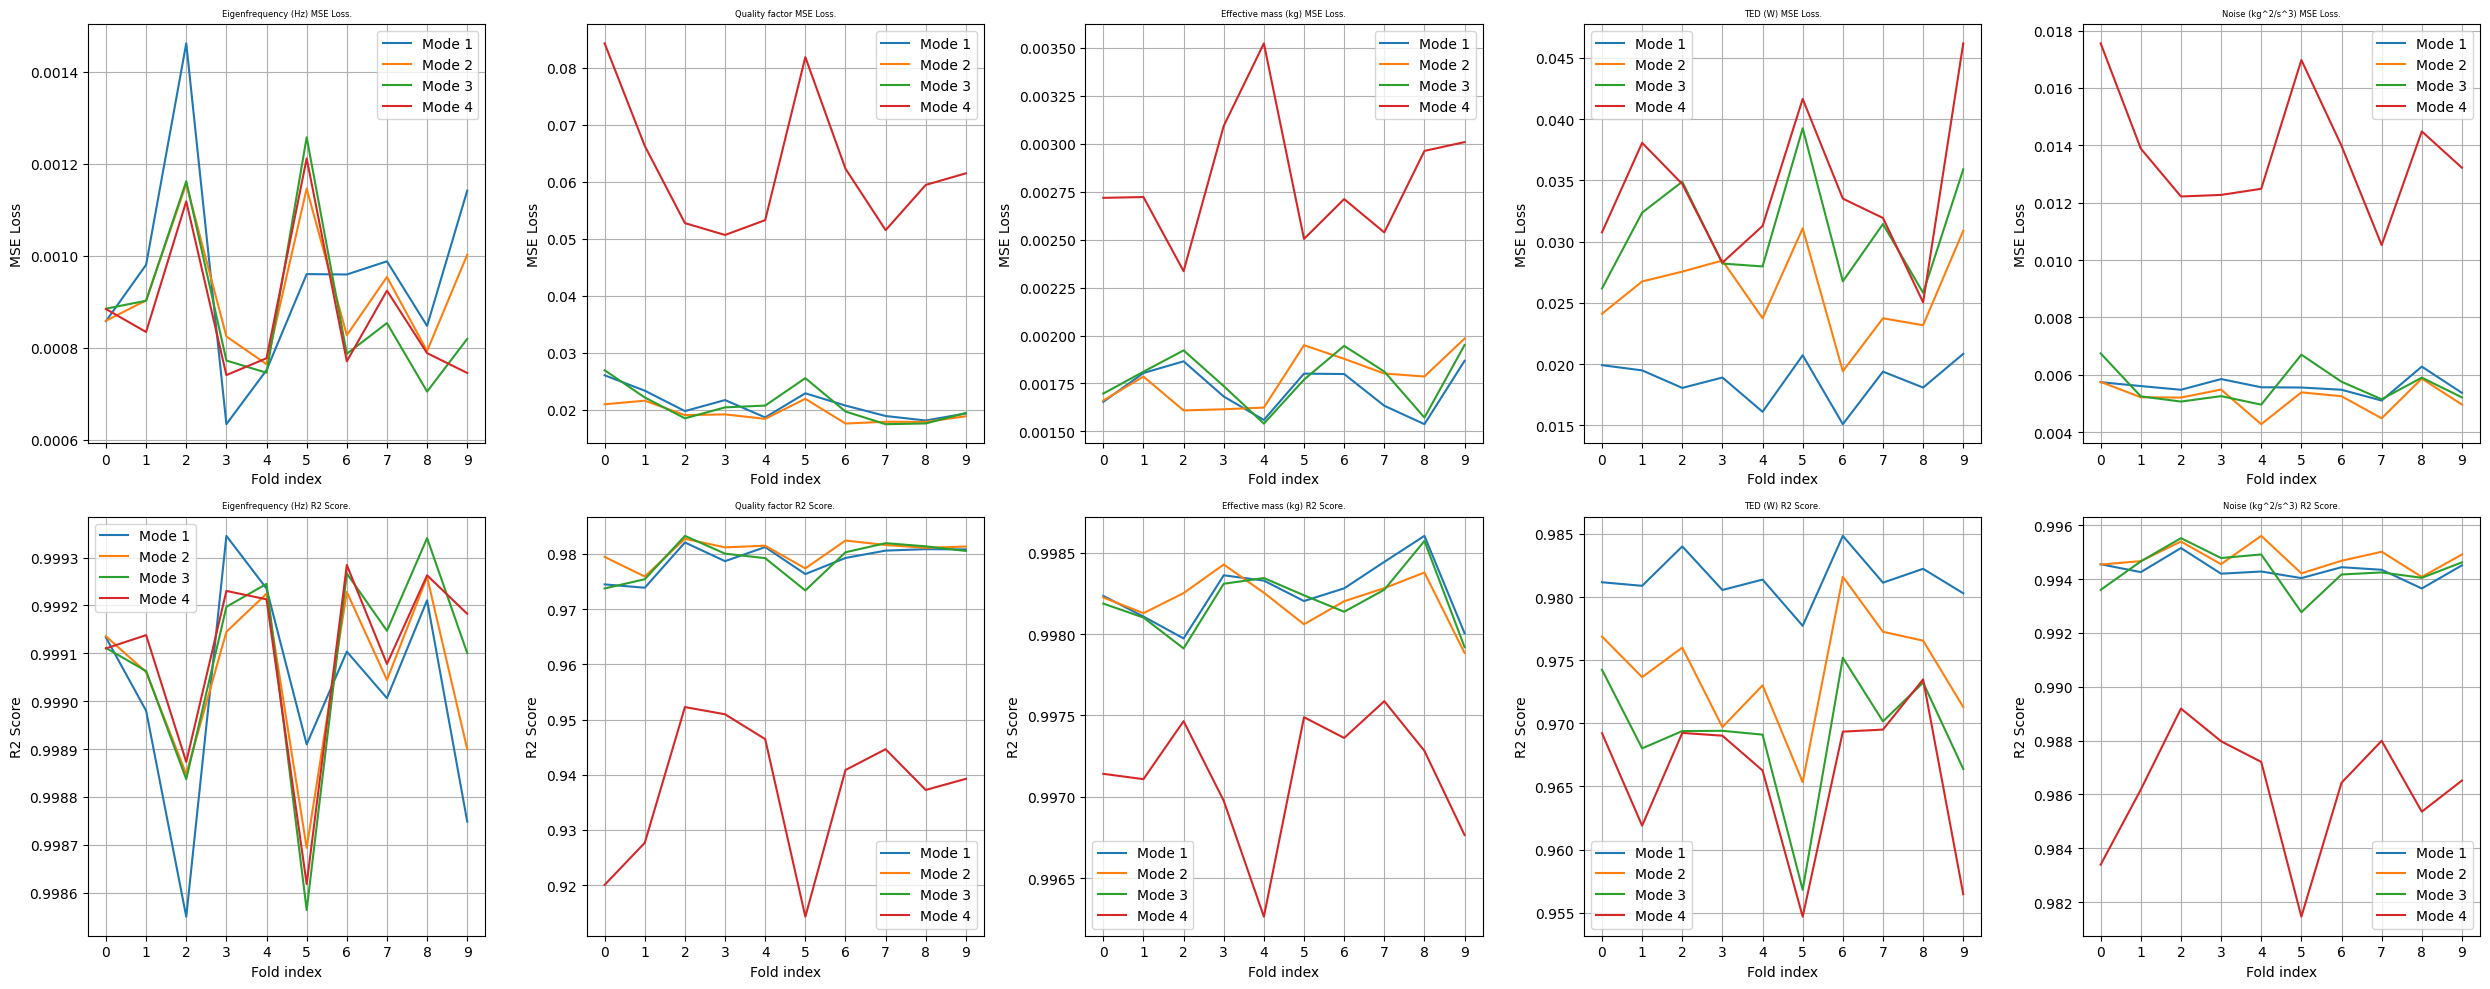

In [ ]:
kf.plot_metrics_folds(apply_log_mse=False, apply_log_r2=False)